In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For nice plots
%matplotlib inline

# Import your MCMC code
from MCMC_Class import DPPM_MCMC, DPPMRegressionMCMC

In [34]:
rng = np.random.default_rng(123)

# Problem dimensions
n_samples = 1000     # number of observations per task
p_features =  1500   # dimension of X (and beta_t)
T_tasks = 100        # number of tasks
K_true = 3         # true number of coefficient clusters / axes

# 1. Generate true orthonormal directions G_true (p x K_true)
A = rng.normal(size=(p_features, K_true))
G_true, _ = np.linalg.qr(A)  # orthonormal columns

# 2. Assign each task to one of the K_true clusters
cluster_sizes = [T_tasks // K_true] * K_true
# distribute leftovers, if any
for i in range(T_tasks - sum(cluster_sizes)):
    cluster_sizes[i] += 1

c_true = np.concatenate([
    np.full(sz, k, dtype=int) for k, sz in enumerate(cluster_sizes)
])
rng.shuffle(c_true)  # shuffle task order

# 3. Generate latent scalar z_t for each task, with cluster-specific means
cluster_means = np.array([1.0, -1.0, 0.5])  # length K_true
cluster_scales = np.array([0.5, 0.5, 0.5])

z_true = np.zeros(T_tasks)
for t in range(T_tasks):
    k = c_true[t]
    z_true[t] = rng.normal(loc=cluster_means[k], scale=cluster_scales[k])

# 4. Construct true beta_t = z_t * g_{c_t}
B_true = np.zeros((p_features, T_tasks))
for t in range(T_tasks):
    k = c_true[t]
    B_true[:, t] = z_true[t] * G_true[:, k]

# 5. Generate design matrix X and responses Y
X = rng.normal(size=(n_samples, p_features))
sigma_eps = 0.5
Y = X @ B_true + sigma_eps * rng.normal(size=(n_samples, T_tasks))

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("B_true shape:", B_true.shape)
print("True cluster counts:", np.bincount(c_true))


X shape: (1000, 1500)
Y shape: (1000, 100)
B_true shape: (1500, 100)
True cluster counts: [34 33 33]


In [36]:
# Choose K <= p_features for the DPPM truncation
K_trunc = 5   # allows model to use up to 5 directions, p=5 here

dppm_reg = DPPMRegressionMCMC(
    X=X,
    Y=Y,
    K=K_trunc,
    alpha=1.0,
    a_tau=.1,
    b_tau=.1,
    a_sigma=.1,
    b_sigma=.1,
    sampler_type="uncollapsed",       # no geomstats required
    step_size_G=0.05,
    random_state=2025,
)

# Run MCMC
dppm_results = dppm_reg.run(
    n_iter=1000,      # increase if you want more thorough mixing
    burn_in=500,
    thin=5,
    store_everything=True,
)

beta_mean_dppm = dppm_results["beta_mean"]  # shape (p_features, T_tasks)
print("beta_mean_dppm shape:", beta_mean_dppm.shape)


Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Iteration  500
Iteration  520
Iteration  540
Iteration  560
Iteration  580
Iteration  600
Iteration  620
Iteration  640
Iteration  660
Iteration  680
Iteration  700
Iteration  720
Iteration  740
Iteration  760
Iteration  780
Iteration  800
Iteration  820
Iteration  840
Iteration  860
Iteration  880
Iteration  900
Iteration  920
Iteration  940
Iteration  960
Iteration  980
beta_mean_dppm shape: (1500, 100)


In [38]:
np.mean(dppm_results['dppm_samples']['G'], axis=0)

array([[-0.01486523,  0.00318459,  0.01897635, -0.02771764,  0.00176305],
       [ 0.00498717, -0.0208191 , -0.01271352, -0.01336799, -0.00141301],
       [ 0.0172868 , -0.00481429, -0.02484026, -0.00696742,  0.00033832],
       ...,
       [ 0.02047098,  0.00051545,  0.01948337,  0.01211945,  0.00281236],
       [ 0.02052369,  0.00175922, -0.0279359 ,  0.05239428,  0.0012707 ],
       [-0.0036923 , -0.00021829,  0.02903105,  0.01871283,  0.00132608]])

In [39]:
# Fit each task independently by OLS
B_ols = np.zeros_like(B_true)
for t in range(T_tasks):
    coef, *_ = np.linalg.lstsq(X, Y[:, t], rcond=None)
    B_ols[:, t] = coef

# Predictions and metrics
Y_hat_ols = X @ B_ols
residuals_ols = Y - Y_hat_ols

rmse_ols = np.sqrt(np.mean(residuals_ols**2))
ss_tot = np.sum((Y - Y.mean(axis=0, keepdims=True))**2)
ss_res_ols = np.sum(residuals_ols**2)
r2_ols = 1.0 - ss_res_ols / ss_tot

print(f"OLS RMSE: {rmse_ols:.3f}")
print(f"OLS R^2:  {r2_ols:.3f}")


OLS RMSE: 0.000
OLS R^2:  1.000


In [40]:
# Predictions using DPPM posterior mean of beta
Y_hat_dppm = X @ beta_mean_dppm
residuals_dppm = Y - Y_hat_dppm

rmse_dppm = np.sqrt(np.mean(residuals_dppm**2))
ss_res_dppm = np.sum(residuals_dppm**2)
r2_dppm = 1.0 - ss_res_dppm / ss_tot

print(f"DPPM-based RMSE: {rmse_dppm:.3f}")
print(f"DPPM-based R^2:  {r2_dppm:.3f}")

print("\nComparison:")
print(f"  OLS      RMSE={rmse_ols:.3f}, R^2={r2_ols:.3f}")
print(f"  DPPM-Pri RMSE={rmse_dppm:.3f}, R^2={r2_dppm:.3f}")


DPPM-based RMSE: 0.495
DPPM-based R^2:  0.803

Comparison:
  OLS      RMSE=0.000, R^2=1.000
  DPPM-Pri RMSE=0.495, R^2=0.803


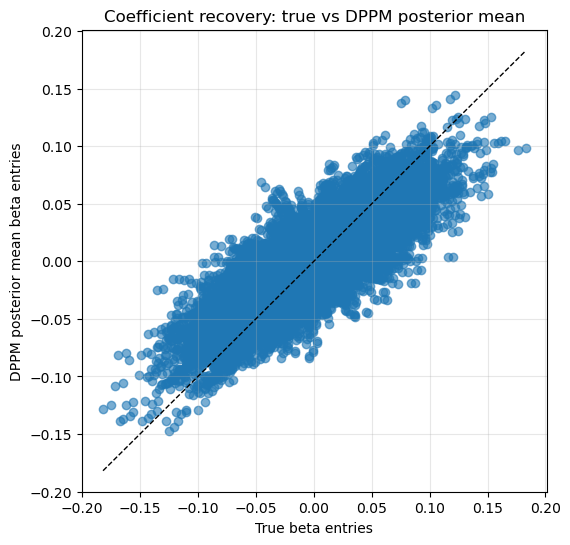

In [41]:
# Flatten for a simple scatter
beta_true_flat = B_true.ravel()
beta_dppm_flat = beta_mean_dppm.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(beta_true_flat, beta_dppm_flat, alpha=0.6)
lims = [min(beta_true_flat.min(), beta_dppm_flat.min()),
        max(beta_true_flat.max(), beta_dppm_flat.max())]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlabel("True beta entries")
plt.ylabel("DPPM posterior mean beta entries")
plt.title("Coefficient recovery: true vs DPPM posterior mean")
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
np.mean(dppm_results['dppm_samples']['G'], axis=0)

array([[-1.65985053e-01, -2.17420372e-01,  3.03454828e-02,
         1.82268850e-02, -3.25991393e-03],
       [ 3.19919353e-02, -7.88805408e-02, -1.47941813e-01,
        -3.27230719e-02,  1.58240093e-02],
       [-1.06754350e-01,  1.00260439e-02, -1.10675834e-01,
        -4.39246242e-03, -8.50006605e-03],
       [-5.52856174e-02,  1.91801471e-01, -2.52371686e-02,
        -1.03514501e-01, -7.93776020e-03],
       [ 2.00461957e-01, -7.69742319e-02,  1.48923227e-01,
        -2.10875171e-03, -1.11537147e-01],
       [ 2.16478577e-02,  7.79721468e-02, -2.52064233e-01,
         4.90270971e-03, -9.66485805e-03],
       [-5.48241684e-02,  2.86283566e-01, -6.71806848e-02,
         2.11949973e-02, -1.21047555e-02],
       [ 1.39204892e-01, -1.36099589e-01, -2.32779453e-01,
        -8.01268600e-03, -4.31390359e-03],
       [ 1.24195358e-01, -1.41041016e-01,  4.77914888e-02,
        -5.64126730e-03, -2.15534595e-03],
       [ 1.80403511e-01,  4.31843940e-02, -3.16034520e-02,
         2.09722418e-02

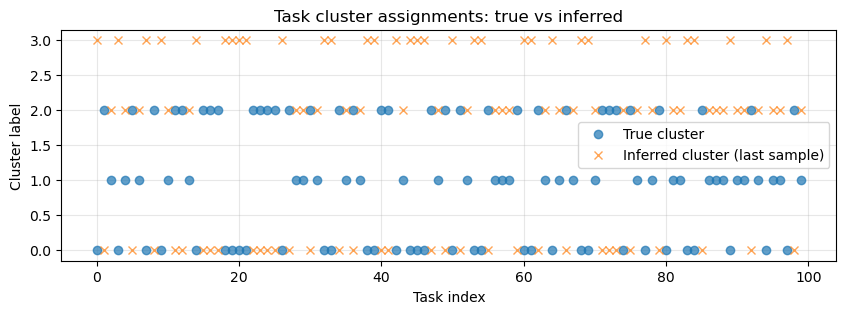

First 20 true vs inferred cluster labels:
Task  0: true=0, inferred=3.0
Task  1: true=2, inferred=0.0
Task  2: true=1, inferred=2.0
Task  3: true=0, inferred=3.0
Task  4: true=1, inferred=2.0
Task  5: true=2, inferred=0.0
Task  6: true=1, inferred=2.0
Task  7: true=0, inferred=3.0
Task  8: true=2, inferred=0.0
Task  9: true=0, inferred=3.0
Task 10: true=1, inferred=2.0
Task 11: true=2, inferred=0.0
Task 12: true=2, inferred=0.0
Task 13: true=1, inferred=2.0
Task 14: true=0, inferred=3.0
Task 15: true=2, inferred=0.0
Task 16: true=2, inferred=0.0
Task 17: true=2, inferred=0.0
Task 18: true=0, inferred=3.0
Task 19: true=0, inferred=3.0


In [42]:
# Grab the last sampled cluster assignments for tasks
c_samps = dppm_results["dppm_samples"]["c"]  # shape (n_kept, T_tasks)
c_hat_last = np.median(dppm_results['dppm_samples']['c'],axis=0)                     # last sample

plt.figure(figsize=(10, 3))
plt.plot(c_true, "o", label="True cluster", alpha=0.7)
plt.plot(c_hat_last, "x", label="Inferred cluster (last sample)", alpha=0.7)
plt.xlabel("Task index")
plt.ylabel("Cluster label")
plt.title("Task cluster assignments: true vs inferred")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("First 20 true vs inferred cluster labels:")
for i in range(min(20, T_tasks)):
    print(f"Task {i:2d}: true={c_true[i]}, inferred={c_hat_last[i]}")


In [43]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix
confusion_matrix(c_hat_last,c_true) 

array([[ 0,  0, 33,  0],
       [ 0,  0,  0,  0],
       [ 1, 33,  0,  0],
       [33,  0,  0,  0]])

In [44]:
# --- basic imports ---
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
# If you want t-SNE / UMAP:
from sklearn.manifold import TSNE
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

# Optional: simple autoencoder with PyTorch
USE_TORCH = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    USE_TORCH = True
except ImportError:
    pass

# --- import your DPPM MCMC implementation ---
# Adjust this import to whatever class/function name you use.
from MCMC_Class import DPPM_MCMC  # e.g. class you wrote for Gibbs sampler


# --- helper functions ---

def orthonormal_matrix(p, K):
    """
    Draw a random p x K orthonormal matrix using QR.
    """
    A = np.random.randn(p, K)
    Q, _ = np.linalg.qr(A)
    return Q[:, :K]


def projection_matrix(G):
    """
    Projection matrix PG = G G^T.
    G: p x K with orthonormal columns.
    """
    return G @ G.T


def frobenius_subspace_error(G_hat, G_true):
    """
    || P_hat - P_true ||_F, where P = G G^T.
    """
    P_hat = projection_matrix(G_hat)
    P_true = projection_matrix(G_true)
    return np.linalg.norm(P_hat - P_true, ord='fro')


def reconstruction_error(X, X_recon):
    """
    Mean squared reconstruction error per point.
    """
    return np.mean(np.sum((X - X_recon) ** 2, axis=1))


def best_cluster_match(true_labels, pred_labels):
    """
    Hungarian matching to compute accuracy between (possibly permuted) labels.
    """
    true_labels = np.asarray(true_labels)
    pred_labels = np.asarray(pred_labels)
    # Build contingency matrix
    D = max(true_labels.max(), pred_labels.max()) + 1
    conf_mat = np.zeros((D, D), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        conf_mat[t, p] += 1
    # Hungarian algorithm to maximize trace
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    accuracy = conf_mat[row_ind, col_ind].sum() / len(true_labels)
    return accuracy


In [45]:
# --- basic imports ---
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
# If you want t-SNE / UMAP:
from sklearn.manifold import TSNE
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

# Optional: simple autoencoder with PyTorch
USE_TORCH = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    USE_TORCH = True
except ImportError:
    pass

# --- import your DPPM MCMC implementation ---
# Adjust this import to whatever class/function name you use.
from MCMC_Class import DPPM_MCMC  # e.g. class you wrote for Gibbs sampler


# --- helper functions ---

def orthonormal_matrix(p, K):
    """
    Draw a random p x K orthonormal matrix using QR.
    """
    A = np.random.randn(p, K)
    Q, _ = np.linalg.qr(A)
    return Q[:, :K]


def projection_matrix(G):
    """
    Projection matrix PG = G G^T.
    G: p x K with orthonormal columns.
    """
    return G @ G.T


def frobenius_subspace_error(G_hat, G_true):
    """
    || P_hat - P_true ||_F, where P = G G^T.
    """
    P_hat = projection_matrix(G_hat)
    P_true = projection_matrix(G_true)
    return np.linalg.norm(P_hat - P_true, ord='fro')


def reconstruction_error(X, X_recon):
    """
    Mean squared reconstruction error per point.
    """
    return np.mean(np.sum((X - X_recon) ** 2, axis=1))


def best_cluster_match(true_labels, pred_labels):
    """
    Hungarian matching to compute accuracy between (possibly permuted) labels.
    """
    true_labels = np.asarray(true_labels)
    pred_labels = np.asarray(pred_labels)
    # Build contingency matrix
    D = max(true_labels.max(), pred_labels.max()) + 1
    conf_mat = np.zeros((D, D), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        conf_mat[t, p] += 1
    # Hungarian algorithm to maximize trace
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    accuracy = conf_mat[row_ind, col_ind].sum() / len(true_labels)
    return accuracy


In [46]:
# --- basic imports ---
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
# If you want t-SNE / UMAP:
from sklearn.manifold import TSNE
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

# Optional: simple autoencoder with PyTorch
USE_TORCH = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    USE_TORCH = True
except ImportError:
    pass

# --- import your DPPM MCMC implementation ---
# Adjust this import to whatever class/function name you use.
from MCMC_Class import DPPM_MCMC  # e.g. class you wrote for Gibbs sampler

# --- helper functions ---

def orthonormal_matrix(p, K):
    """
    Draw a random p x K orthonormal matrix using QR.
    """
    A = np.random.randn(p, K)
    Q, _ = np.linalg.qr(A)
    return Q[:, :K]


def projection_matrix(G):
    """
    Projection matrix PG = G G^T.
    G: p x K with orthonormal columns.
    """
    return G @ G.T


def frobenius_subspace_error(G_hat, G_true):
    """
    || P_hat - P_true ||_F, where P = G G^T.
    """
    P_hat = projection_matrix(G_hat)
    P_true = projection_matrix(G_true)
    return np.linalg.norm(P_hat - P_true, ord='fro')


def reconstruction_error(X, X_recon):
    """
    Mean squared reconstruction error per point.
    """
    return np.mean(np.sum((X - X_recon) ** 2, axis=1))


def best_cluster_match(true_labels, pred_labels):
    """
    Hungarian matching to compute accuracy between (possibly permuted) labels.
    """
    true_labels = np.asarray(true_labels)
    pred_labels = np.asarray(pred_labels)
    # Build contingency matrix
    D = max(true_labels.max(), pred_labels.max()) + 1
    conf_mat = np.zeros((D, D), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        conf_mat[t, p] += 1
    # Hungarian algorithm to maximize trace
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    accuracy = conf_mat[row_ind, col_ind].sum() / len(true_labels)
    return accuracy
